SANTIAGO MONDELO LAGOMARSINO, JORGE SÁEZ SALTO , MIGUEL XUCLÁ HERRERO

<div style="text-align: center; font-size: 36px;">
    <strong>BLACKJACK</strong>
</div>
<p style="text-align: center;">Practica sesion 4:  Q-learning</p>


En esta práctica hemos decidido implementar el aprendizaje por refuerzo basado en Q-Learning para resolver el problema de toma de decisiones en el juego de Blackjack, utilizando el entorno proporcionado por Gymnasium. A través de esta implementación, aplicaremos las técnicas y conceptos que hemos visto en clase, como la actualización de la matriz Q, el uso de estrategias de exploración-explotación y la gestión de parámetros clave como α (alpha), γ (gamma) y ε (epsilon). Además, realizaremos diversas pruebas para evaluar el rendimiento del agente en distintas condiciones, con el objetivo de contrastar los resultados obtenidos y extraer conclusiones sobre la efectividad del algoritmo de Q-Learning en este contexto.

Métodos de la clase gymnasium:

    reset(self) : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

    step(self, action) : "Avanza" un timestep. Devuelve: observation, reward, done, info.

    render(self) : Muestra en pantalla el entorno.

    close(self) : Finaliza con la instancia del agente.

    seed(self) : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.

Atributos de la clase gymnasium:

    action_space : El objeto de tipo Space correspondiente al espacio de acciones válidas.

    observation_space : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

    reward_range : Tupla que contiene los valores mínimo y máximo de recompensa posible.


Para calcular la posición en la matriz he empleado la siguiente fórmula:

### 20 * (A - minSuma) + (B - 1) + 10 * C

Siendo A la suma acumulada del jugador, B la carta que muestra el dealer y C es 1 o 0 en función de si el as se usa como 11 o como 1 respectivamente

minSuma es la suma mínima que puede acumular el jugador, es decir, 4

La matriz tiene 360 posiciones puesto que max(A) = 21, max(B) = 10 y max(C) = 1 que al sustituirlo en la fórmula da 359 (cuando la suma del jugador supere 21 se devolverá un valor negativo para indicar que es una acción penalizada)


Importamos las librerias necesarias: gymnasium random, numpy y matplot para generar las graficas.

In [521]:
import gymnasium as gym
import numpy as npy
import random as rng
import matplotlib.pyplot as plot

In [523]:
from IPython.display import clear_output

Creamos la simulación y inicializamos la matriz Q con tamaño maxvalor ya que son todos los estados posibles mencioandos anteriormente

In [526]:
env = gym.make('Blackjack-v1', natural=True, sab=False)
#env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode = "human")

maxValor = 360
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

<div style="text-align: center; font-size: 20px;">
    <strong>Función de simulación</strong>
</div>

###  Usando la fórmula: Q(s,t) = (1 - a) Q(s,t) + a(r + a max(Q(s’,t’)))

In [529]:
def Aprendizaje_Parametros(alpha, gamma, epsilon, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng):
    # Inicialización de contadores de premios y castigos
    contCastigos = 0
    contPremios = 0
    
    # Asignación de los parámetros de aprendizaje (α, γ, ε)
    a = alpha    # Parámetro de aprendizaje (α) que controla la tasa de actualización de la matriz Q
    y = gamma    # Factor de descuento (γ) que pondera las recompensas futuras
    e = epsilon  # Parámetro de exploración (ε) que controla el equilibrio entre exploración y explotación

    # Bucle principal para los episodios
    for i in range(episodios):
    
        # Si 'dinamico' es True, ajustamos los parámetros a lo largo de los episodios
        if dinamico:
            # Ajuste dinámico de los parámetros: reducción de la exploración y el aprendizaje a lo largo del tiempo
            a = 1 - (i / (episodios + 1))
            y = i / (episodios + 1)
            e = 1 - (i / (episodios + 1))
    
        # Reiniciamos el entorno al principio de cada episodio
        estado = env.reset()
        A, B, C = estado[0]  # Estado dividido en tres variables (por ejemplo, cartas en Blackjack)
        
        # Cálculo de la "posición" única para este estado en la matriz Q
        pos = 20 * (A - minSuma) + (B - 1) + 10 * C
        
        # Inicializamos la variable 'done' para controlar el fin del episodio
        done = False
    
        # Bucle interno: mientras no se termine el episodio
        while not done:
            # Si el valor aleatorio es menor que 'ε', exploramos (acción aleatoria)
            if rng.uniform(0, 1) < e:
                accion = env.action_space.sample()
            else:  # Si no, explotamos (usamos la política actual: la mejor acción conocida)
                accion = npy.argmax(matrizQ[pos]) 
    
            # Ejecutamos la acción y obtenemos el nuevo estado, recompensa, y si el episodio terminó
            estadoNext, recompensa, done, info, info2 = env.step(accion)
    
            # Ajustamos la recompensa por un factor 'ourMod' (puede ser útil para ajustar escalas)
            recompensa *= ourMod
            
            # Extraemos las nuevas características del estado
            nextA, nextB, nextC = estadoNext
            
            # Calculamos la "posición" en la matriz Q para el siguiente estado
            posNext = 20 * (nextA - minSuma) + (nextB - 1) + 10 * nextC
            
            # Si el siguiente estado es inválido (por ejemplo, en Blackjack, una suma mayor a 21),
            # se le asigna un valor negativo
            siguienteMax = npy.max(matrizQ[posNext]) if posNext < maxValor else -ourMod
    
            # Obtenemos el valor actual de la matriz Q para el estado-acción actual
            valorAntiguo = matrizQ[pos, accion]
            
            # Aplicamos la fórmula de actualización de Q-Learning
            # (Valor nuevo = valor anterior + tasa de aprendizaje * [recompensa + descuento * valor máximo futuro - valor actual])
            valorNuevo = (1 - a) * valorAntiguo + a * (recompensa + y * siguienteMax)
            
            # Actualizamos la matriz Q con el nuevo valor calculado
            matrizQ[pos, accion] = valorNuevo
            
            # Contabilizamos si hubo un castigo o un premio
            if recompensa < 0: 
                contCastigos += 1
            elif recompensa > 0: 
                contPremios += 1
            
            # Actualizamos el estado y la posición para el siguiente ciclo
            estado = estadoNext
            pos = posNext

        # Cada 100 episodios, mostramos el progreso
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    # Al finalizar, mostramos el total de episodios completados
    clear_output(wait=True)
    print(f"Episode: {episodios}")
    
    # Almacenamos el total de premios y castigos por episodio
    premios.append(contPremios)
    castigos.append(contCastigos)


<div style="text-align: center; font-size: 20px;">
    <strong>Funcion de gráfico (premios y castigos)</strong>
</div>

In [532]:
def graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod):
    """
    Genera un gráfico de premios y castigos con anotaciones y etiquetas personalizadas.

    Args:
        premios (list): Lista de cantidades de premios por simulación.
        castigos (list): Lista de cantidades de castigos por simulación.
        episodios (int): Número de episodios por simulación.
        a (float): Parámetro α del algoritmo.
        y (float): Parámetro γ del algoritmo.
        e (float): Parámetro ε del algoritmo.
        reiniciado (bool): Indica si la matriz fue reiniciada.
        ourMod (float): Factor multiplicador de recompensas.
    """
    x = [i for i in range(1, len(premios) + 1)]
    
    # Graficar premios y castigos
    plot.plot(x, premios, marker='o', label="Premios")
    plot.plot(x, castigos, marker='o', label="Castigos")
    
    # Anotaciones en los puntos
    for ab in zip(x, premios):
        plot.annotate('(%d, %d)' % ab, xy=ab)
    for ab in zip(x, castigos):
        plot.annotate('(%d, %d)' % ab, xy=ab)

    # Configuración de etiquetas y título
    font = {'family': 'serif', 'color': 'black', 'size': 9}
    plot.ylabel("Cantidad de premios (azul)/castigos (naranja)", fontdict=font)
    plot.xlabel(f"Nº simulación de {episodios} episodios", fontdict=font)
    plot.title(f"Premios y castigos con parámetros α = {a}, γ = {y}, ε = {e} "
               f"(Matriz {'reiniciada' if reiniciado else 'sin reiniciar'} y recompensas multiplicadas por {ourMod})", fontdict=font)
    
    # Configuración de rejilla y mostrar gráfico
    plot.grid()
    plot.legend()
    plot.show()

<div style="text-align: center; font-size: 20px;">
    <strong>Celdas de parámetros y test</strong>
</div>

# Prueba: Q-Learning con Parámetros Fijos
En esta prueba, implementaremos el algoritmo de **Q-Learning** para entrenar a un agente a jugar Blackjack. Utilizaremos **parámetros fijos** en la fórmula de actualización del algoritmo, y las configuraciones específicas son las siguientes:

# Primer Test:

- **Estado de la matriz Q**:
  - `reiniciado = npy.all(matrizQ == 0)`: Determinaremos si la matriz Q ha sido reiniciada.
  
- **Configuración del aprendizaje**:

  - `a = 0.75`: Valor de **α (alpha)**, el factor de aprendizaje.
  - `y = 0.8`: Valor de **γ (gamma)**, el factorde descuento.
  - `e = 0.15`: Valor de **ε (epsilon)**, que controla la exploración frente a la explotación

- **Configuración de la simulación**:
  - `episodios = 10000`: Número de episodios que ejecutará la simulación.
  - `dinamico = False`: Los parámetros no cambiarán dinámicamente durante la ejecución.
  
- **Recompensas y castigos**:
  - `ourMod = 1`: Modificador auxiliar para ajustar las recompensas predeterminadas.
  - `premios`: Lista que almacenará el número de premios por simulación.
  - `castigos`: Lista que almacenará el número de castigos por simulación.
  
- **Cálculo de posiciones en la matriz**:
  - `minSuma = 4`: Valor mínimo necesario para calcular las posiciones dentro de la matriz Q.

Esta prueba ayudará a evaluar el comportamiento del algoritmo con **parámetros constantes** en el contexto del Blackjack. El objetivo es optimizar el aprendizaje del agente y analizar los resultados en términos de premios y castigos.

In [536]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])
reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0.75 #Valor de alpha (α) 
y = 0.8 #Valor de gamma (γ)
e = 0.15 #Valor de epsilon (ε)
episodios = 10000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = False

Para los test utilizaremos un for para hacer 10 simulaciones de 10.000 episodios para realizar una comparación válida.

Episode: 10000


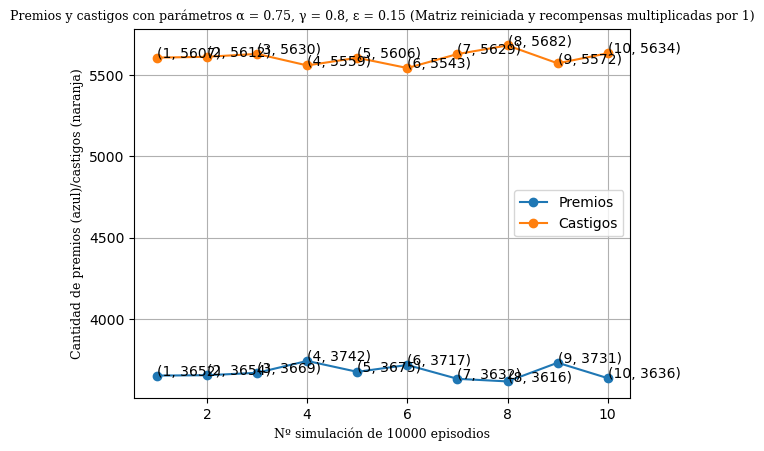

CPU times: total: 812 ms
Wall time: 13.3 s


In [539]:
%%time
for i in range (10):
    Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)


Para esta prueba, se ha usado un parámetro alpha moderado de valor 0.75, lo que dará bastante más importancia al nuevo valor del estado. Esto resulta útil para lograr un aprendizaje más rápido en menos episodios. El valor de gamma, con un valor medio-alto de 0.8, asigna mayor importancia a las recompensas y decisiones de los estados futuros. Por último, epsilon tiene un valor intermedio de 0.15, lo que da un 15% de probabilidad de exploración.

# Segundo Test:

- **Estado de la matriz Q**:
  - `reiniciado = npy.all(matrizQ == 0)`: Determinaremos si la matriz Q ha sido reiniciada.
  
- **Configuración del aprendizaje**:
  - `a = 0.5`: Valor de **α (alpha)**, el factor de aprendizaje.
  - `y = 0.5`: Valor de **γ (gamma)**, el factor de descuento.
  - `e = 0.2`: Valor de **ε (epsilon)**, que controla la exploración frente a la explotación.

In [543]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0.5 #Valor de alpha (α) 
y = 0.5 #Valor de gamma (γ)
e = 0.2 #Valor de epsilon (ε)
episodios = 10000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = False

Episode: 10000


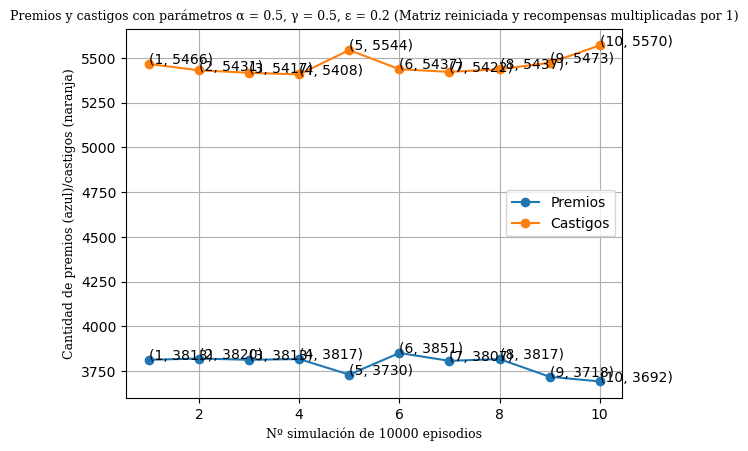

CPU times: total: 1.16 s
Wall time: 13.1 s


In [545]:
%%time
for i in range (10):
    Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)


Para esta prueba, se ha usado un parámetro alpha moderado con un valor de 0.5, lo que da la misma importancia tanto al estado previo como al nuevo. El parámetro gamma define cuánta importancia se le da a las decisiones y recompensas futuras. Un valor de 0.5 asigna igual importancia a las recompensas actuales y futuras. Por último, epsilon tiene un valor intermedio de 0.2, lo que permite realizar exploración en el 20% de los casos.

# Tercer Test:

- **Estado de la matriz Q**:
  - `reiniciado = npy.all(matrizQ == 0)`: Determinaremos si la matriz Q ha sido reiniciada.
  
- **Configuración del aprendizaje**:
  - `a = 0.9`: Valor de **α (alpha)**, el factor de aprendizaje.
  - `y = 0`: Valor de **γ (gamma)**, el factor de descuento.
  - `e = 0.15`: Valor de **ε (epsilon)**, que controla la exploración frente a la explotación.


In [549]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0.9 #Valor de alpha (α) 
y = 0 #Valor de gamma (γ)
e = 0.15 #Valor de epsilon (ε)
episodios = 10000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = False

Episode: 10000


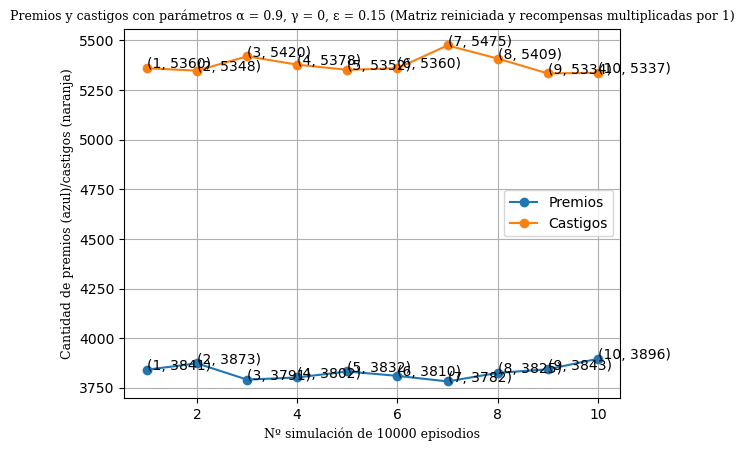

CPU times: total: 953 ms
Wall time: 13.7 s


In [551]:
%%time
for i in range (10):
    Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)


Para esta prueba, se usa un parámetro alpha con un valor muy alto de 0.9, lo que da casi total importancia a los nuevos valores de cada estado, haciendo que cada decisión tenga un impacto significativo en futuras decisiones. Se utiliza un gamma nulo (0), lo que elimina la importancia de las recompensas futuras; es decir, el valor de cada estado no considera decisiones o recompensas posteriores. Por último, se configura un valor intermedio de epsilon (0.15), lo que implica un 15% de probabilidad de exploración.

# Prueba: Q-Learning con Parámetros Variables

En esta prueba, implementaremos el algoritmo de **Q-Learning** para entrenar a un agente a jugar Blackjack. Utilizaremos **parámetros variables** en la fórmula de actualización del algoritmo, y las configuraciones específicas son las siguientes:


# Test:

- **Estado de la matriz Q**:
  - `reiniciado = npy.all(matrizQ == 0)`: Determinaremos si la matriz Q ha sido reiniciada.
  
- **Configuración del aprendizaje**:
  - `a = 1 - (i/(episodios+1))`: Valor de **α (alpha)**, el factor de aprendizaje.
  - `y = (i/(episodios+1))`: Valor de **γ (gamma)**, el factor de descuento.
  - `e = 1 - (i/(episodios+1))`: Valor de **ε (epsilon)**, que controla la exploración frente a la explotación.
- **Configuración de la simulación**:
  - `episodios = 10000`: Número de episodios que ejecutará la simulación.
  - `dinamico = True`: Los parámetros cambiarán dinámicamente durante la ejecución.


In [556]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0
y = 0
e = 0
episodios = 10000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = True

Episode: 10000


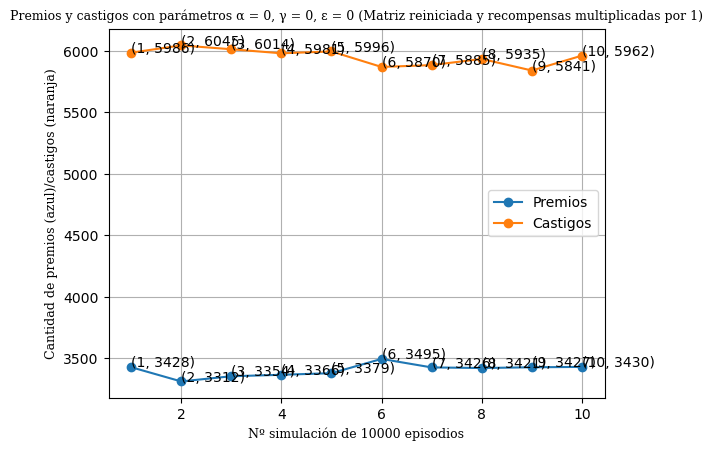

CPU times: total: 1 s
Wall time: 13 s


In [558]:
%%time
for i in range (10):
    Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)


Aquí se observa la utilización de variables dinámicas, como alpha, que se va reduciendo basándose en que, cuantos más episodios pasen, menor importancia tienen los nuevos valores de estado. Para gamma, ocurre lo contrario, ya que, cuantos más episodios transcurren, mayor será la importancia de las decisiones futuras. Por último, para epsilon, este valor también decrece, ya que, al considerar que las decisiones del agente son cada vez más sólidas, la necesidad de realizar exploración disminuye.

# Simulación con un caso muy grande (1.000.000) Dinámicos vs Fijos

In [584]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0.9 #Valor de alpha (α) 
y = 0 #Valor de gamma (γ)
e = 0.15 #Valor de epsilon (ε)
episodios = 1000000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = False

Episode: 1000000


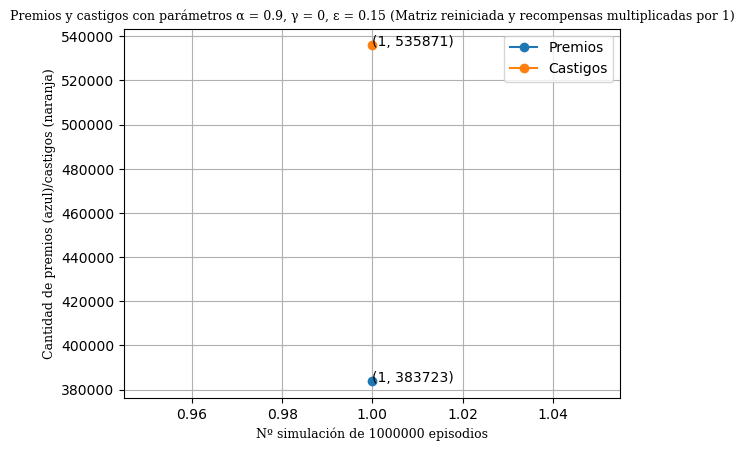

CPU times: total: 9.58 s
Wall time: 2min 13s


In [586]:
%%time
Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)

In [587]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0
y = 0
e = 0
episodios = 1000000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = True

Episode: 1000000


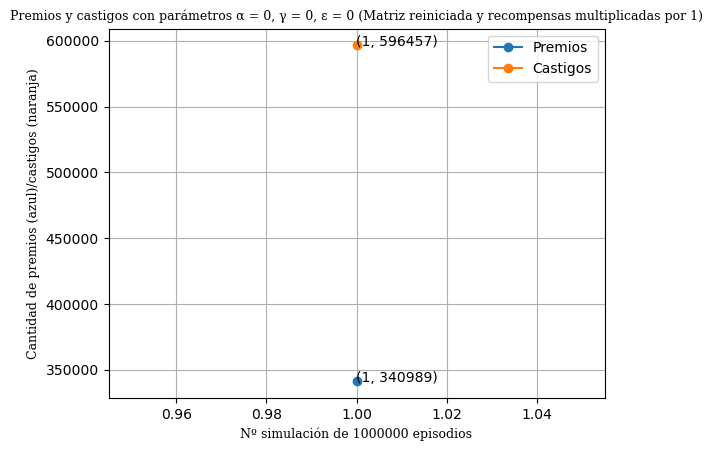

CPU times: total: 10.8 s
Wall time: 2min 8s


In [588]:
%%time
Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)


En esta prueba, el aprendizaje con parámetros fijos es un 12,53% mejor en cuanto a recompensas que el dinámico y además tiene 11,3% menos de castigo.

# Conclusión:

Para concluir, a continuacion vamos a volver a ejecutar uno de los casos de test con epsilon 0 (es decir en explotación) para verificar cuanto aprende el agente.

In [622]:
#Inicializo toda la Matriz Q-Learning a 0 (Dimensiones de 360x2)
matrizQ = npy.zeros([maxValor, env.action_space.n])

reiniciado = npy.all(matrizQ == 0) #Miro si la matriz Q ha sido reiniciada o no
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
a = 0.9 #Valor de alpha (α) 
y = 0 #Valor de gamma (γ)
e = 0.15 #Valor de epsilon (ε)
episodios = 100000 #Numero de episodios que se van a ejecutar por simulacion
ourMod = 1 #Modificador auxiliar por si queremos aumentar o disminuir la recompensa predeterminada
#castigos = 0 #Numero de penalizaciones que se han recibido
minSuma = 4 #Valor necesario para calcular las posiciones en la matriz
dinamico = False

Episode: 100000


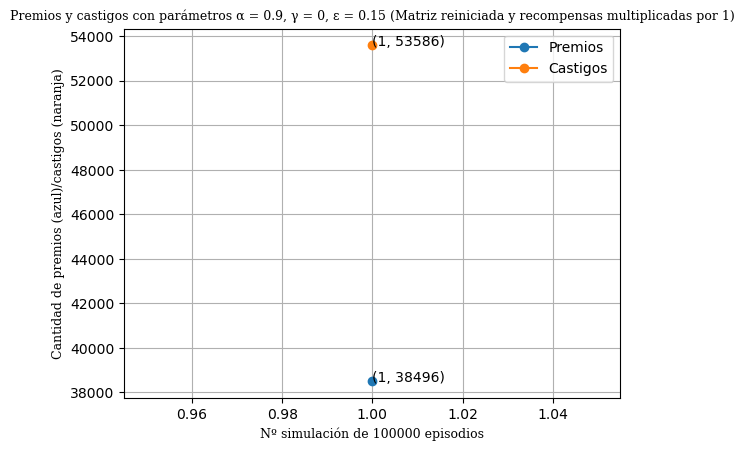

CPU times: total: 1.92 s
Wall time: 13.6 s


In [624]:
%%time
Aprendizaje_Parametros(a,y,e, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)

Episode: 10000


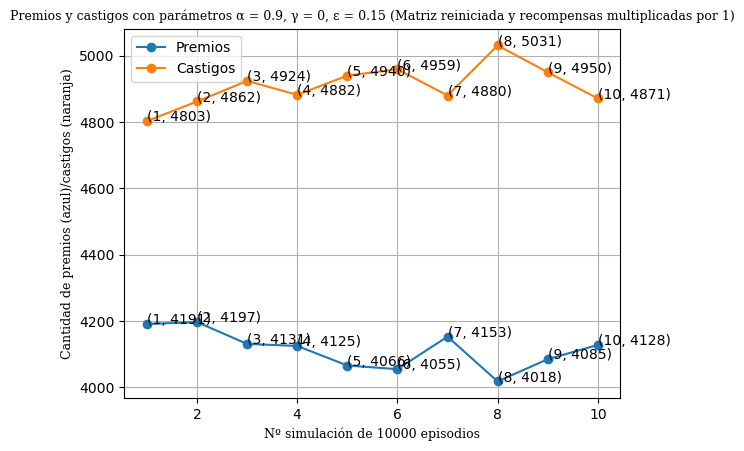

CPU times: total: 3.3 s
Wall time: 13.8 s


In [628]:
%%time
premios = [] #Lista que almacena la cantidad de premios que ha habido en cada simulacion
castigos = [] #Lista que almacena la cantidad de castigos que ha habido en cada simulacion
episodios = 10000
for i in range (10):
    Aprendizaje_Parametros(a,y,0, dinamico, env, minSuma, ourMod, matrizQ, maxValor, premios, castigos, rng)
graficar_premios_castigos(premios, castigos, episodios, a, y, e, reiniciado, ourMod)

Mejora con respecto a cuando esta en aprendizaje pero la diferencia de castigos y recompensas sigue siendo razonablemente grande.

En esta práctica, implementamos Q-Learning para entrenar un agente a jugar Blackjack. Sin embargo, debido a la aleatoriedad del juego, la toma de decisiones es más compleja que en otros problemas más deterministas, como esquivar agujeros en un tablero, donde siempre hay una solución clara. En Blackjack, el agente debe adaptarse a situaciones inciertas, como las cartas ocultas del dealer, lo que hace que las decisiones no sean siempre las mismas.

Aunque el algoritmo Q-Learning funciona bien, la exploración-explotación es un desafío en este entorno estocástico. A pesar de ajustar los parámetros como α (alpha), γ (gamma) y ε (epsilon), la aleatoriedad sigue influyendo en el rendimiento. Esto muestra que, aunque Q-Learning es potente, los problemas con mucha incertidumbre requieren ajustes finos en los parámetros y en cómo representamos el estado del juego para mejorar los resultados.

De aqui podemos deducir porque en todas las pruebas (las mostradas en el notebook y las que hemos realizado por nuestra cuenta) la tasa de recompensas por cada perdidas es de un 40% aproximadamente.